In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sktime.forecasting.arima import AutoARIMA

In [2]:
data = pd.read_csv('parkingLot.csv')
data

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [3]:
# data['vehicle_no'].fillna('Unknown', inplace=True)
data['time'] = pd.to_datetime(data['timestamp'])
# data['date'] = pd.to_datetime(data['timestamp'])
data['date'] = data['time'].dt.date
# if time stamp time is 00 00 then make it's date as previous date
data.loc[data['time'].dt.time == datetime.time(0, 0), 'date'] = data['date'] - pd.Timedelta(days=1)
data

,vehicle_no,timestamp,camera_id,time,date
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
4,MHHA0518,2024-09-12 05:00:00,1,2024-09-12 05:00:00,2024-09-12
...,...,...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106690,MHVY8418,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106691,MHSR8102,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13
106692,MHQG5264,2024-11-14 00:00:00,2,2024-11-14 00:00:00,2024-11-13


In [4]:
data['camera_1'] = data['camera_id'] == 1
data['camera_2'] = data['camera_id'] == 2
data['camera_1'] = 1 * data['camera_1']
data['camera_2'] = 1 * data['camera_2']

In [5]:
data.groupby('timestamp').sum(numeric_only=True)
daily_data = data.groupby('date').sum(numeric_only=True)

In [6]:
# train an ARIMA model to predict the number of vehicles in the parking lot
# Plot PACF and ACF to determine the order of the ARIMA model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

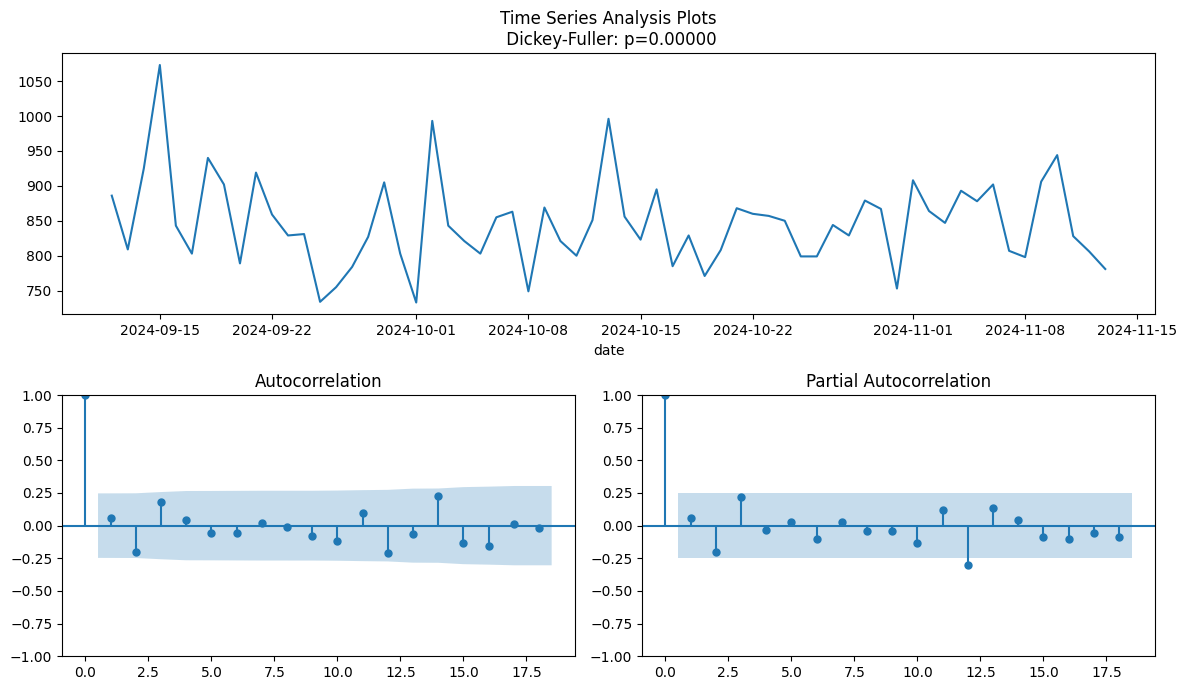

In [7]:
tsplot(daily_data['camera_1'])

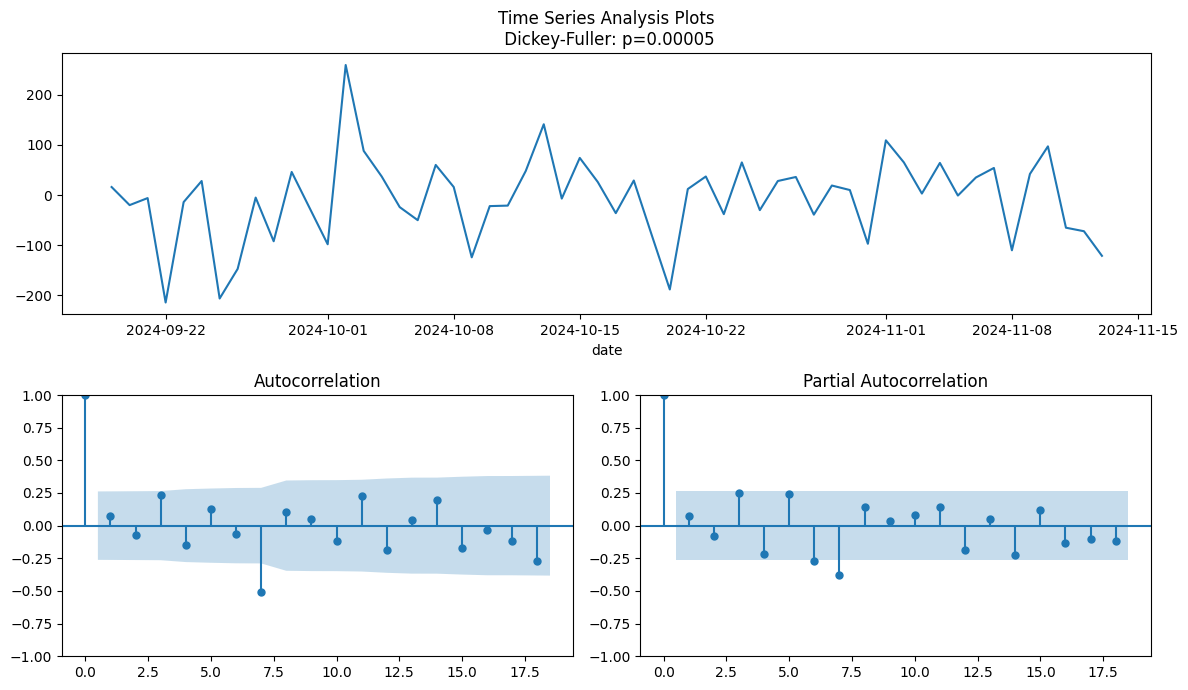

In [8]:
daily_data_diff = daily_data['camera_1'].diff(periods=7).dropna()
tsplot(daily_data_diff)

In [10]:
train_size = 56  # 80% for training, 20% for testing
train, test = daily_data[:train_size], daily_data[train_size:]

In [11]:
from pmdarima import auto_arima
auto_model = auto_arima(train['camera_1'],
                        # start_p=0, max_p=14,    # Range of values for p
                        # start_q=0, max_q=14,    # Range of values for q
                        p = None,               # Let auto_arima determine the best p
                        q = None,               # Let auto_arima determine the best q
                        d = 0,                # Let auto_arima determine the best d
                        seasonal=True,         # Enable seasonal differencing
                        m=7,                   # Weekly seasonality
                        # start_P=0, max_P=14,    # Range of values for seasonal P
                        # start_Q=0, max_Q=14,    # Range of values for seasonal Q
                        P=None,                # Let auto_arima determine the best P
                        Q=None,                # Let auto_arima determine the best Q

                        D=None,                # Let auto_arima determine the best D
                        trace=True,            # Print results for each model tested
                        # error_action='ignore', # Ignore models that don’t fit
                        suppress_warnings=True,
                        stepwise=True)         # Stepwise search for faster execution

# Display the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=631.952, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=628.083, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=631.929, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=631.835, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=916.412, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=630.083, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=638.936, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=632.015, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=629.978, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=629.922, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=631.996, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 1.834 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model: 

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['camera_1'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -6.945367069760149
p-value: 1.0004233434079317e-09


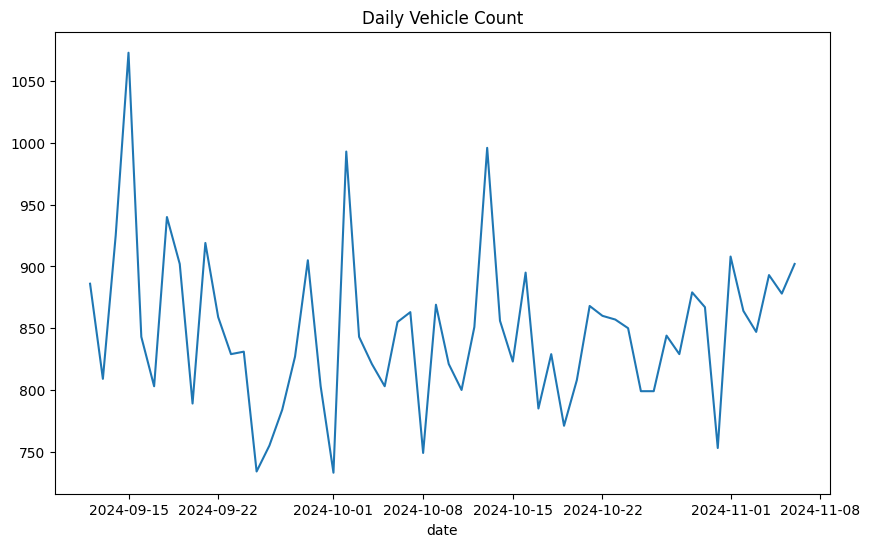

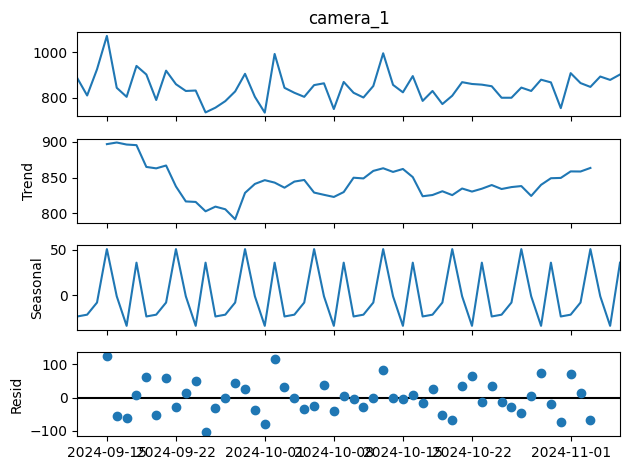

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot original data
train['camera_1'].plot(title="Daily Vehicle Count", figsize=(10,6))
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(train['camera_1'], period=7)
decomposition.plot()
plt.show()

/home/balaji/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                 camera_1   No. Observations:                   56
Model:             ExponentialSmoothing   SSE                         203102.437
Optimized:                         True   AIC                            480.982
Trend:                         Additive   BIC                            503.261
Seasonal:                      Additive   AICC                           489.649
Seasonal Periods:                     7   Date:                 Mon, 28 Oct 2024
Box-Cox:                          False   Time:                         22:44:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0849354                alpha                 True
smoothing_trend          

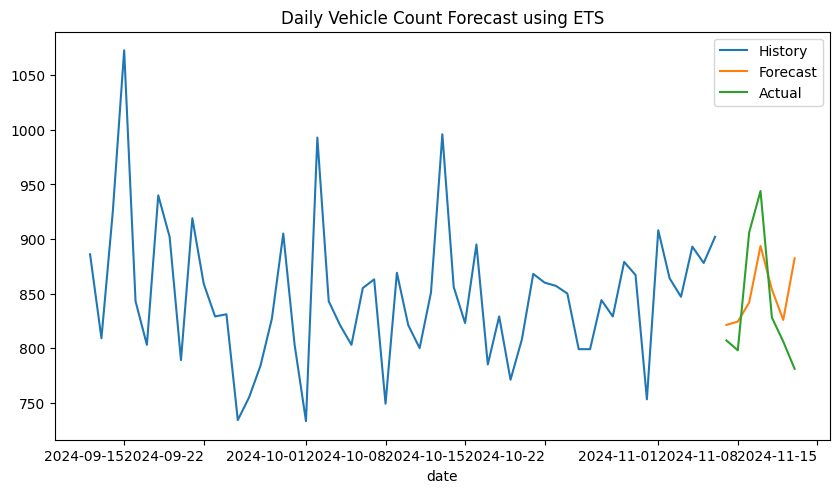

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming df_daily is your DataFrame containing the daily vehicle counts
# Fit the ETS model (additive trend and seasonality)
ets_model = ExponentialSmoothing(train['camera_1'], 
                                 trend='add', 
                                 seasonal='add', 
                                 seasonal_periods=7).fit()

# Print summary of the ETS model
print(ets_model.summary())

# Forecast for the next 7 days
forecast = ets_model.forecast(7)
print(forecast)

# Plotting the forecast against the actual data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
train['camera_1'].plot(label='History', legend=True)
forecast.plot(label='Forecast', legend=True)
test['camera_1'].plot(label='Actual', legend=True)
plt.title('Daily Vehicle Count Forecast using ETS')
plt.show()

date
2024-11-07    -14.253719
2024-11-08    -26.257625
2024-11-09     64.222103
2024-11-10     50.406682
2024-11-11    -25.704968
2024-11-12    -19.795615
2024-11-13   -101.305055
dtype: float64


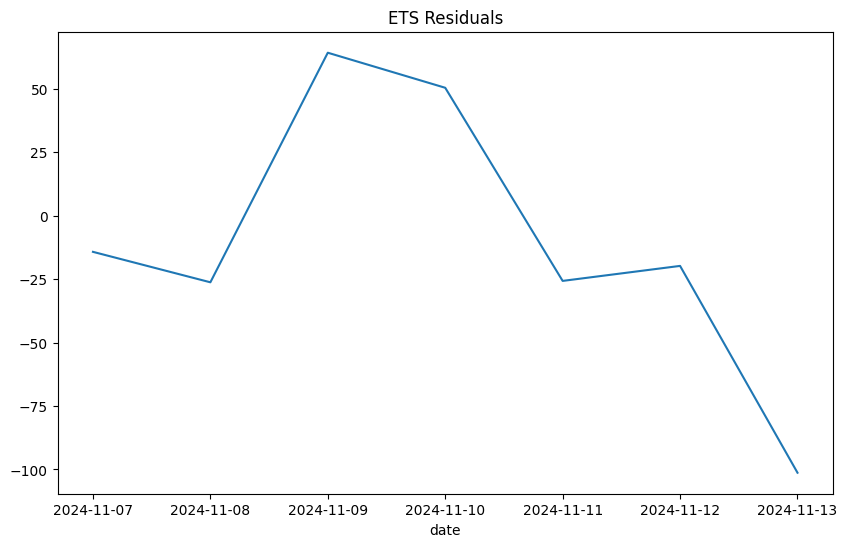

In [15]:
ets_residuals = test['camera_1'] - forecast
# print(train['camera_1'])
# print(forecast)
print(ets_residuals)
plt.figure(figsize=(10,6))
ets_residuals.plot(title='ETS Residuals')
plt.show()

In [17]:
def mean_absolute_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    
    y_true - array-like of true values
    y_pred - array-like of predicted values
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Scaled Error (MASE)
    
    y_true - array-like of true values
    y_pred - array-like of predicted values
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error (MAE)
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))  # Mean Absolute Error of naive forecast
    return mae / naive_mae

In [33]:
forecast_df = auto_model.predict(7)
forecast_df

2024-11-07    847.803571
2024-11-08    847.803571
2024-11-09    847.803571
2024-11-10    847.803571
2024-11-11    847.803571
2024-11-12    847.803571
2024-11-13    847.803571
Freq: D, dtype: float64

In [38]:
mape = mean_absolute_percentage_error(test['camera_1'], forecast_df)
mae = mean_absolute_error(test['camera_1'], forecast_df)
mase = mean_absolute_scaled_error(test['camera_1'], forecast_df)
print(f"MAPE using ARIMA: {mape:.2f}%")
print(f"MAE using ARIMA: {mae:.2f}")
print(f"MASE using ARIMA: {mase:.2f}%")

MAPE using ARIMA: 6.29%
MAE using ARIMA: 53.34
MASE using ARIMA: 1.01%


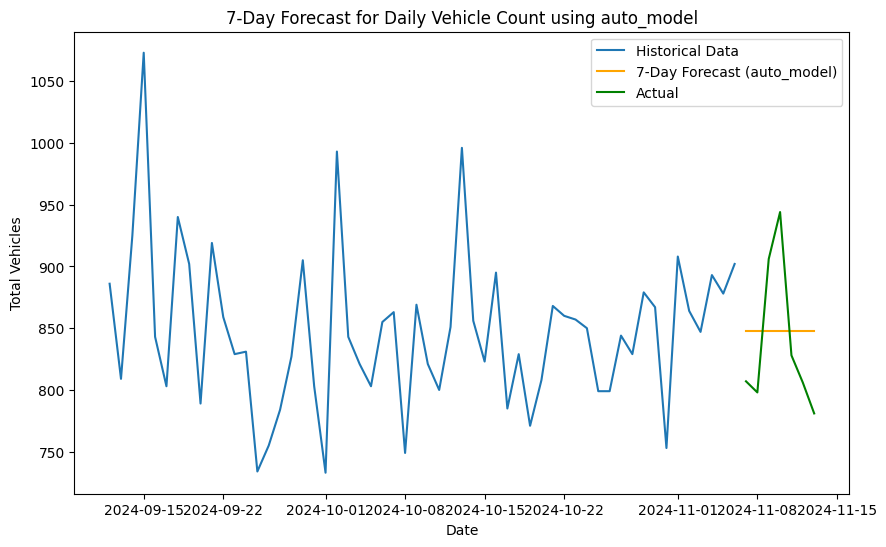

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['camera_1'], label='Historical Data')
plt.plot(test.index, forecast_df, label='7-Day Forecast (auto_model)', color='orange')
plt.plot(test.index, test['camera_1'], label='Actual', color='green')

plt.xlabel('Date')
plt.ylabel('Total Vehicles')
plt.title('7-Day Forecast for Daily Vehicle Count using auto_model')
plt.legend()
plt.show()

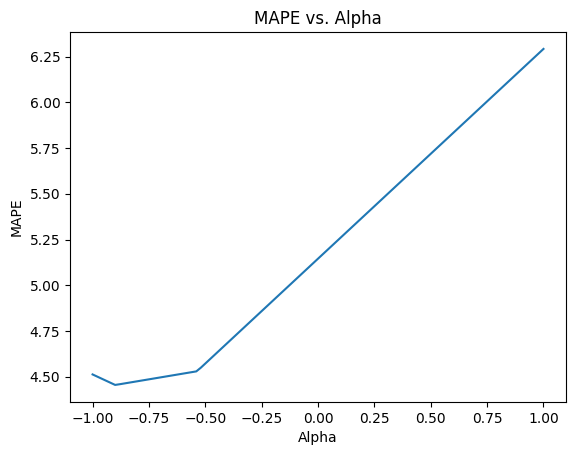

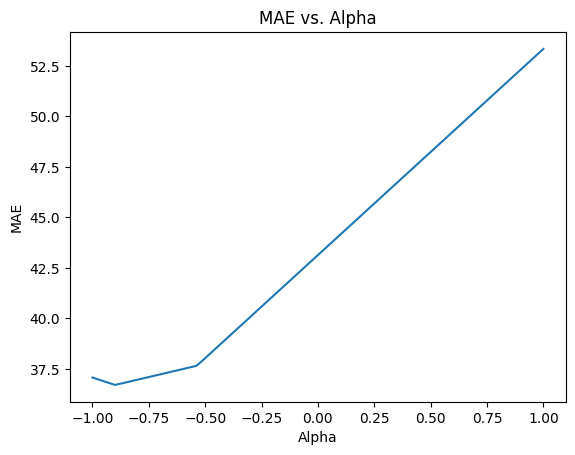

min alpha:  -0.9
MAPE using ensemble model: 4.46%
MAE using ensemble model: 36.70
MASE using ensemble model: 0.69


In [42]:
mape_vs_alpha = []
mae_vs_alpha = []
alphas = []
for alpha in np.linspace(-1, 1, 101):
    ensemble_forecast = alpha * forecast_df + (1 - alpha) * forecast
    mape_ensemble = mean_absolute_percentage_error(test['camera_1'], ensemble_forecast)
    mae_ensemble = mean_absolute_error(test['camera_1'], ensemble_forecast)
    mape_vs_alpha.append(mape_ensemble)
    mae_vs_alpha.append(mae_ensemble)
    alphas.append(alpha)
    # print(f"MAPE using ensemble model: {mape_ensemble:.2f}%")
    # print(f"MAE using ensemble model: {mae_ensemble:.2f}")
plt.plot(alphas, mape_vs_alpha)
plt.xlabel('Alpha')
plt.ylabel('MAPE')
plt.title('MAPE vs. Alpha')
plt.show()
plt.plot(alphas, mae_vs_alpha)
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.title('MAE vs. Alpha')
plt.show()
print("min alpha: ", alphas[np.argmin(mape_vs_alpha)])
alpha = -0.9
# beta = 0.6
beta = 1-alpha
ensemble_forecast = alpha * forecast_df + beta * forecast
mape_ensemble = mean_absolute_percentage_error(test['camera_1'], ensemble_forecast)
mae_ensemble = mean_absolute_error(test['camera_1'], ensemble_forecast)
print(f"MAPE using ensemble model: {mape_ensemble:.2f}%")
print(f"MAE using ensemble model: {mae_ensemble:.2f}")
print(f"MASE using ensemble model: {mean_absolute_scaled_error(test['camera_1'], ensemble_forecast):.2f}")

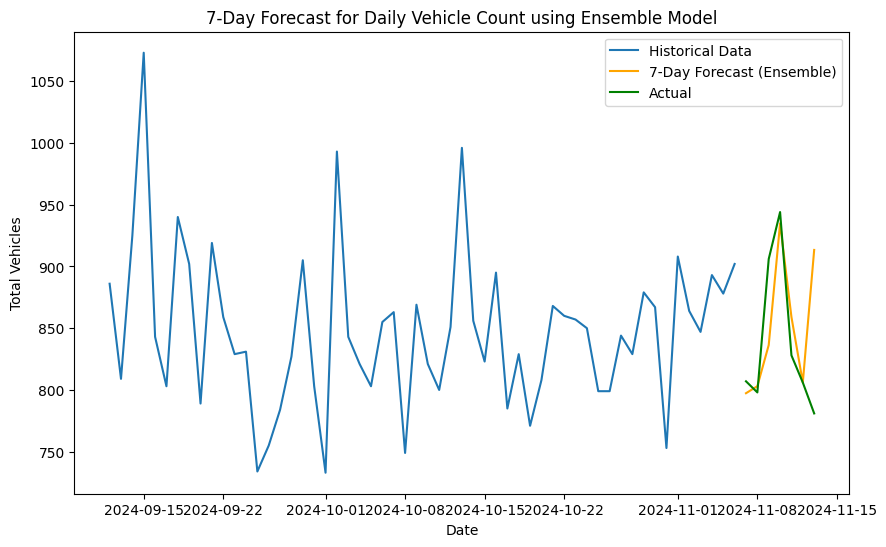

In [44]:
final_ensemble_prediction = alpha * forecast_df + beta * forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['camera_1'], label='Historical Data')
plt.plot(test.index, final_ensemble_prediction, label='7-Day Forecast (Ensemble)', color='orange')
plt.plot(test.index, test['camera_1'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Total Vehicles')
plt.title('7-Day Forecast for Daily Vehicle Count using Ensemble Model')
plt.legend()
plt.show()